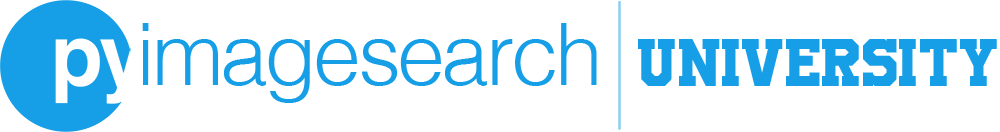

# U-Net: Training Image Segmentation Models in PyTorch
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [U-Net: Training Image Segmentation Models in PyTorch](https://www.pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/) blog post published on 2021-11-08.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook.

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [6]:
#%cd drive/MyDrive/Colab
#!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/unet-tgs-salt-pytorch/unet-tgs-salt-pytorch.zip
#!unzip -qq unet-tgs-salt-pytorch.zip
#%cd unet-tgs-salt-pytorch

/content/drive/MyDrive/Colab
--2023-10-20 21:36:17--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/unet-tgs-salt-pytorch/unet-tgs-salt-pytorch.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.176.114, 3.5.82.212, 52.92.242.138, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.176.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 493187 (482K) [application/zip]
Saving to: ‘unet-tgs-salt-pytorch.zip’

unet-tgs-salt-pytor 100%[===================>] 481.63K   722KB/s    in 0.7s    

2023-10-20 21:36:19 (722 KB/s) - ‘unet-tgs-salt-pytorch.zip’ saved [493187/493187]

/content/drive/MyDrive/Colab/unet-tgs-salt-pytorch


### Downloading the dataset

Since this dataset is hosted on Kaggle, we have a few options to get the dataset from Kaggle to our Colab Notebook environment -

* Download the dataset from Kaggle as a zipped file, upload that to our Google Drive, and then mount Google Drive on Colab to access the uploaded dataset.
* Use the [Kaggle API](https://github.com/Kaggle/kaggle-api) to directly download the dataset to our Colab Notebook environment.

We will be using the second option. **Note** that you need to obtain your Kaggle API keys to perform this step. Follow the instructions [here](https://github.com/Kaggle/kaggle-api) in order to obtain your Kaggle API keys in case you don't have them.

Now, navigate to File Browser of Colab and upload your keys following [this screencast](https://www.loom.com/share/ca76bb983e0844e2a7f14b473d7287c6). After the keys file has been uploaded, we need to move it to an appropriate location.

In [9]:
#!mkdir ~/.kaggle
#!cp /content/drive/MyDrive/Colab/kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Now, we can download the dataset.

In [10]:
#!kaggle competitions download -c tgs-salt-identification-challenge -f train.zip

100% 37.9M/37.9M [00:04<00:00, 16.8MB/s]
100% 37.9M/37.9M [00:04<00:00, 9.65MB/s]


To follow along with the rest of the code, please move the download dataset by executing the command below.

In [12]:
#!mkdir -p dataset/train
#!mv train.zip dataset/train
#%cd dataset/train
#!unzip -qq train.zip
#!rm train.zip


mv: cannot stat 'train.zip': No such file or directory
/content/drive/MyDrive/Colab/unet-tgs-salt-pytorch/dataset/train/dataset/train
unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.
rm: cannot remove 'train.zip': No such file or directory
/content/drive/MyDrive/Colab/unet-tgs-salt-pytorch


In [5]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/Colab')
%cd /content/drive/MyDrive/Colab/unet-tgs-salt-pytorch

Mounted at /content/drive/


## Blog Post Code

### Import Packages

In [13]:
# import the necessary packages
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import cv2
import time

### Define the configuration

In [14]:
class Config:
    # base path of the dataset
    DATASET_PATH = os.path.join("dataset", "train")

    # define the path to the images and masks dataset
    IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
    MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

    # define the test split
    TEST_SPLIT = 0.15

    # determine the device to be used for training and evaluation
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # determine if we will be pinning memory during data loading
    PIN_MEMORY = True if DEVICE == "cuda" else False

    # define the number of channels in the input, number of classes,
    # and number of levels in the U-Net model
    NUM_CHANNELS = 1
    NUM_CLASSES = 1
    NUM_LEVELS = 3

    # initialize learning rate, number of epochs to train for, and the
    # batch size
    INIT_LR = 0.001
    NUM_EPOCHS = 40
    BATCH_SIZE = 64

    # define the input image dimensions
    INPUT_IMAGE_WIDTH = 128
    INPUT_IMAGE_HEIGHT = 128

    # define threshold to filter weak predictions
    THRESHOLD = 0.5

    # define the path to the base output directory
    BASE_OUTPUT = "output"

    # define the path to the output serialized model, model training
    # plot, and testing image paths
    MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
    TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

config = Config()

### Define the dataset utils

In [15]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)

	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]

		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)

		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)

		# return a tuple of the image and its mask
		return (image, mask)

### Define the U-Net model

In [16]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)

	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [17]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []

		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)

		# return the list containing the intermediate outputs
		return blockOutputs

In [18]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)

			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)

		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)

		# return the cropped features
		return encFeatures

In [19]:
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)

		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)

		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])

		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)

		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)

		# return the segmentation map
		return map

### Define the data pipeline

In [20]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=config.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((config.INPUT_IMAGE_HEIGHT,
		config.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] saving testing image paths...
[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


### Train the model

In [ ]:
# initialize our UNet model
unet = UNet().to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()

		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)

# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

[INFO] training the network...


  2%|▎         | 1/40 [00:27<17:40, 27.19s/it]

[INFO] EPOCH: 1/40
Train loss: 0.582593, Test loss: 0.6109


  5%|▌         | 2/40 [00:45<13:50, 21.86s/it]

[INFO] EPOCH: 2/40
Train loss: 0.571263, Test loss: 0.6078


  8%|▊         | 3/40 [01:08<13:44, 22.27s/it]

[INFO] EPOCH: 3/40
Train loss: 0.568737, Test loss: 0.6066


 10%|█         | 4/40 [01:28<12:52, 21.47s/it]

[INFO] EPOCH: 4/40
Train loss: 0.564705, Test loss: 0.5986


 12%|█▎        | 5/40 [01:48<12:16, 21.03s/it]

[INFO] EPOCH: 5/40
Train loss: 0.554108, Test loss: 0.5791


 15%|█▌        | 6/40 [02:08<11:45, 20.74s/it]

[INFO] EPOCH: 6/40
Train loss: 0.514115, Test loss: 0.4810


 18%|█▊        | 7/40 [02:28<11:16, 20.49s/it]

[INFO] EPOCH: 7/40
Train loss: 0.452895, Test loss: 0.4420


 20%|██        | 8/40 [02:48<10:44, 20.15s/it]

[INFO] EPOCH: 8/40
Train loss: 0.461572, Test loss: 0.4494


### Predict using the trained model

In [ ]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)

	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")

	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [ ]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()

	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0

		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()

		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)

		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
			config.INPUT_IMAGE_HEIGHT))

		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(config.DEVICE)

		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()

		# filter out the weak predictions and convert them to integers
		predMask = (predMask > config.THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


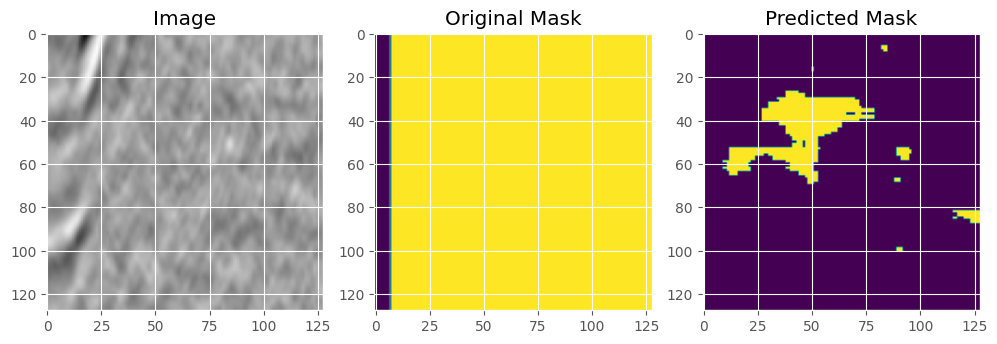

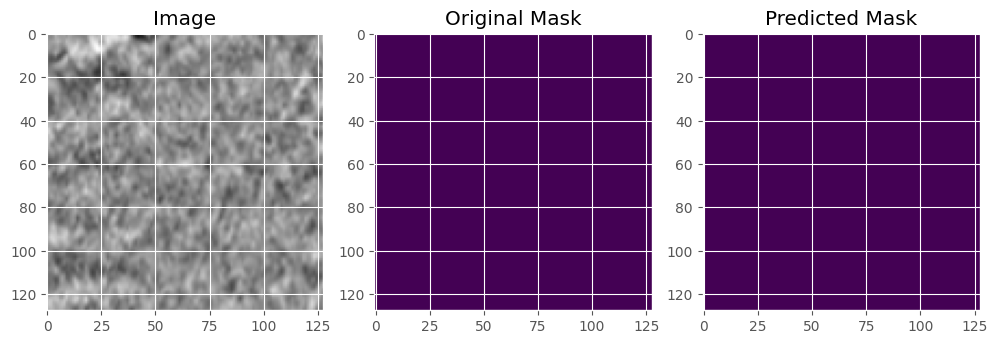

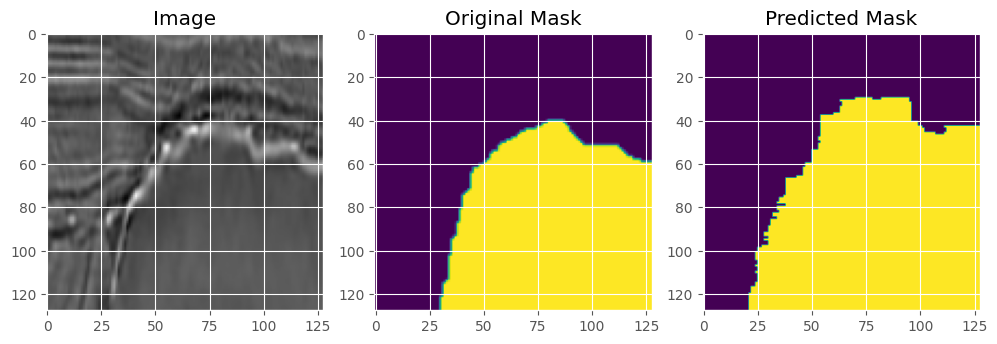

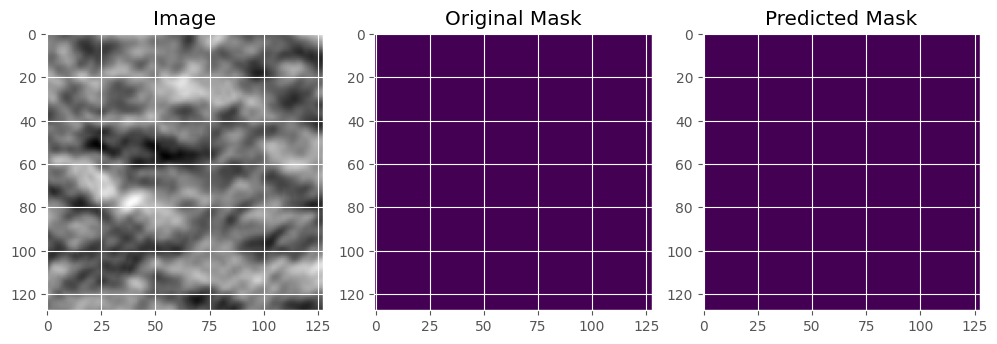

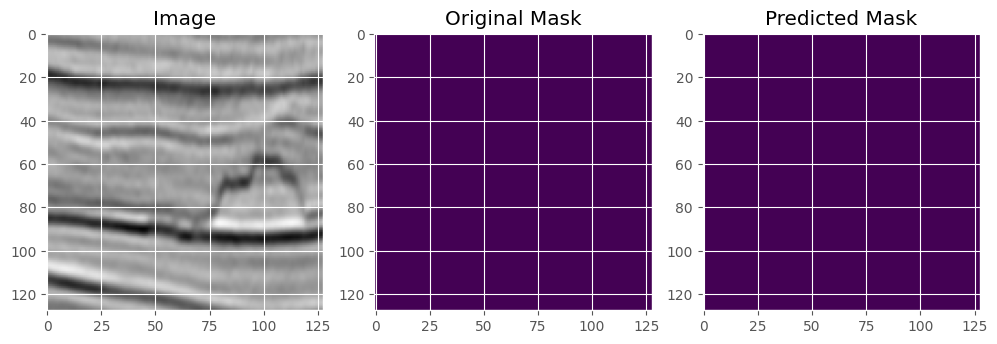

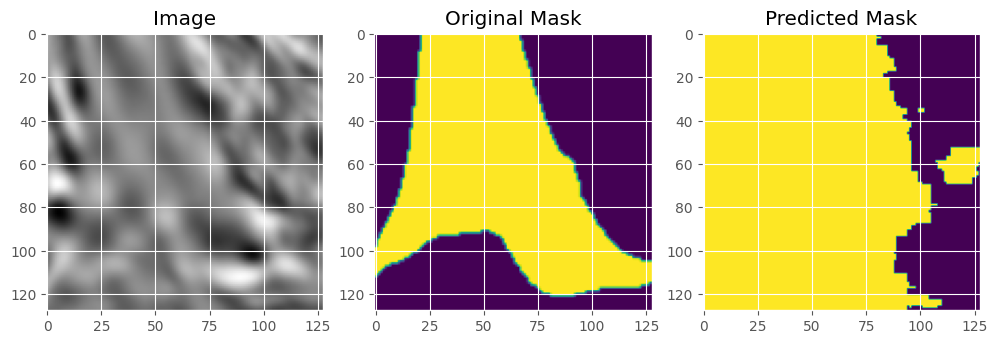

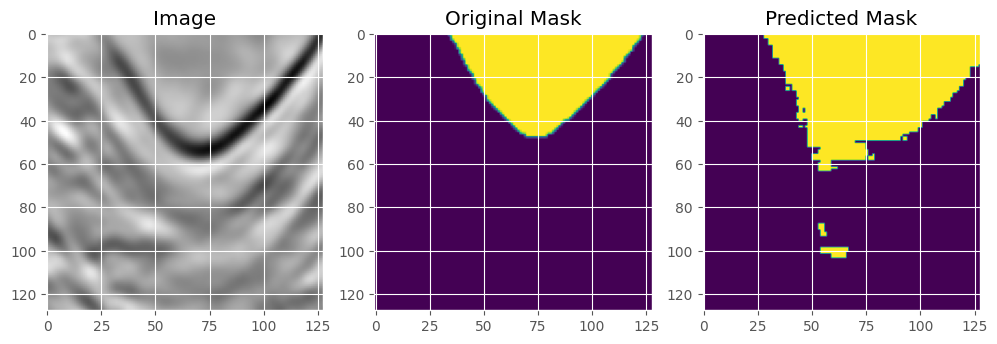

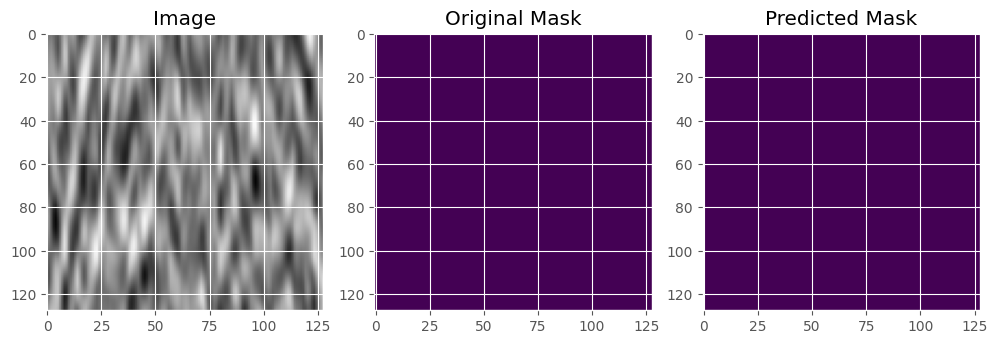

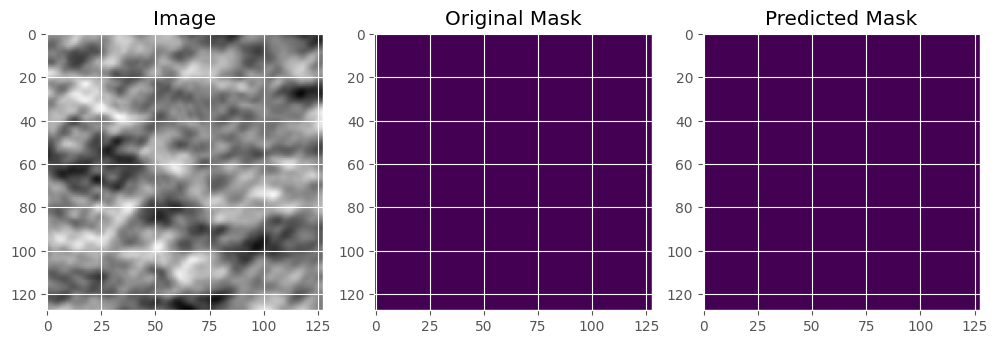

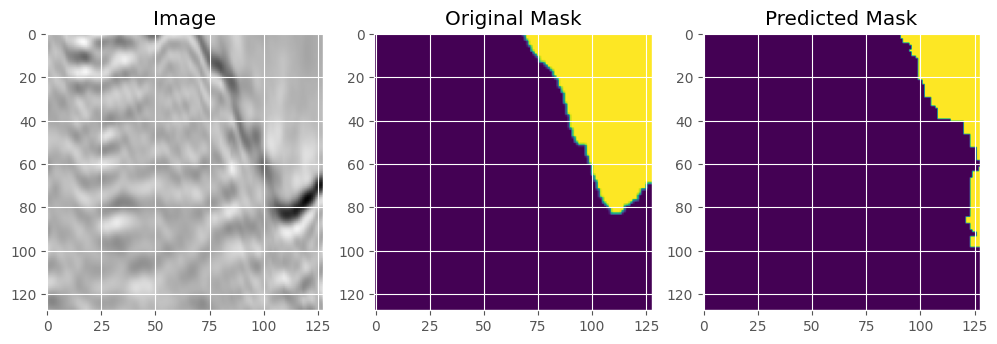

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=200)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*U-Net: Training Image Segmentation Models in PyTorch*](https://www.pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/) published on 2021-11-08.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```